In [7]:
%matplotlib inline 
import cv2, os, ast, time, math, shutil, sys, glob 
from datetime import datetime
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas() 
from joblib import Parallel, delayed

import torch
import torchvision
from torchvision.ops import box_iou
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from matplotlib.image import imread

In [2]:
%cd yolov7
cwd = os.getcwd()

h:\Python\ob\train_models\YOLO\yolov7


In [ ]:
batch_size = 4
epochs = 12

In [ ]:
time_begin = time.time() 

!python train.py --img 960 560 \
--batch {batch_size} \
--data data/cots.yaml \
--epochs {epochs} \
--cfg cfg/training/yolov7_cots.yaml \
--weights yolov7.pt \
--name yolov7_cots \
--hyp data/hyp.scratch.p5.yaml

print('Training Completed and time used:', time.time() - time_begin)

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ckpt_path = 'h:/Python/ob/train_models/YOLO/runs_yolov7_960_560/weights/best.pt'

In [4]:
from models.experimental import attempt_load 
from utils.datasets import LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression
model = attempt_load(ckpt_path, map_location=device)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block


In [10]:
def detect_cots(img_path, model, img_size, stride, device): 
    
    dataset = LoadImages(img_path, img_size=img_size, stride=stride)

    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device).float()
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)
    # Inference
        pred = model(img, augment=None)[0]
        pred = non_max_suppression(pred) #opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
    print('Inference used:', time.time() - t0)
    return pred

def yolo2xy(bboxes, height=720, width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    # denormalizing
    bboxes[..., 0::2] *= width
    bboxes[..., 1::2] *= height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., 0:2] -= bboxes[..., 2:4]/2
    bboxes[:,[2]] += bboxes[:,[0]]
    bboxes[:,[3]] += bboxes[:,[1]]
    
    return bboxes

Inference used: 0.14058542251586914
[[509 210 556 251]]
[[629  68 675 104]
 [386 160 417 185]]
Inference used: 0.0836176872253418
[]
[[372 466 393 490]
 [464 138 489 159]
 [628 234 668 273]
 [543 339 582 370]
 [467 351 504 388]
 [507 378 539 413]
 [483 392 522 434]]
Inference used: 0.08741021156311035
[]
[[415 443 470 508]
 [434  27 464  59]]
Inference used: 0.08616828918457031
[[295 281 320 305]]
[[264 455 302 493]
 [193 391 222 415]
 [189 255 226 284]
 [315 310 339 331]
 [197 453 219 474]]


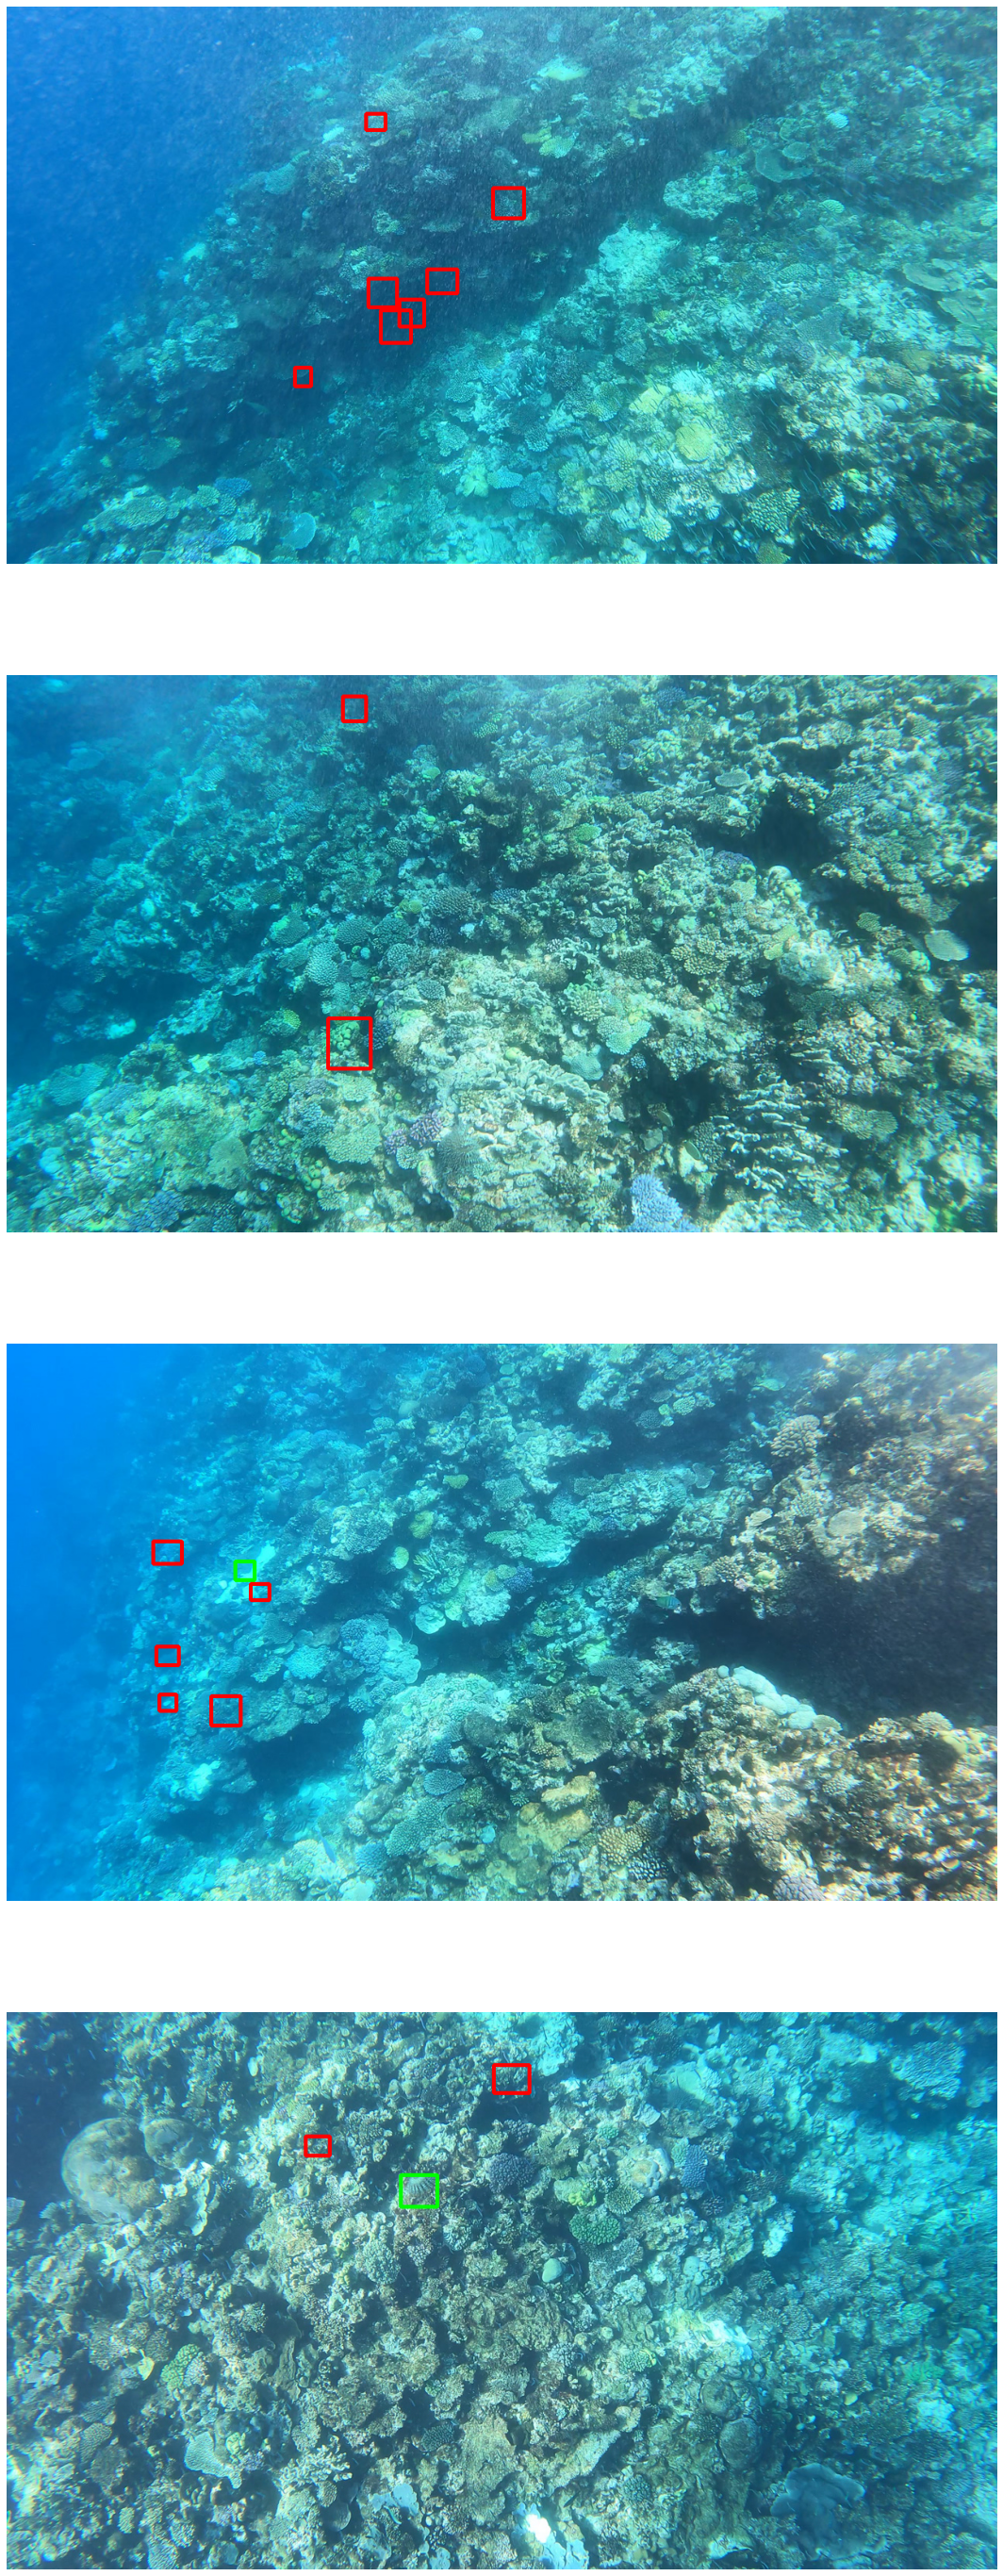

In [11]:
df_val = pd.read_csv('./cots/val.txt', header=None, names=['img_path'])
random_sample = np.random.randint(0, 491, size=4)
preds = []
bboxes = []
col_names={0:'class', 1:'x_mid', 2:'y_mid', 3:'w_ratio', 4:'h_ratio'}

fig, ax = plt.subplots(4, 1, figsize=(100, 50))

for i in range(len(random_sample)):
    img_path = df_val.img_path[random_sample[i]]
    label_path = img_path.replace('jpg', 'txt')
    label_path = label_path.replace('images', 'labels')
    img = imread(img_path).astype(np.int32)
    pred = detect_cots(img_path, model=model, img_size=1280, stride=32, device=device)
    pred = pred[0].detach().cpu().numpy()
    preds.append(pred)
    pred_box = pred[:, 0:4].astype(np.int32)
    pred_conf = pred[:, 4]
    print(pred_box)
    bbox = pd.read_csv(label_path, sep=' ', header=None)
    bbox = bbox.rename(columns=col_names)
    bbox = bbox[['x_mid', 'y_mid', 'w_ratio', 'h_ratio']]
    bboxes.append(bbox.to_numpy())
    gt_box = yolo2xy(bbox.to_numpy()).astype(np.int32)
    print(gt_box)
    
    # Red for ground truth
    for box in gt_box:
        cv2.rectangle(img,(box[0], box[1]),(box[2], box[3]),(255, 0, 0), 3)

    # Green for predictions
    for box in pred_box:
        cv2.rectangle(img,(box[0], box[1]),(box[2], box[3]),(0, 255, 0), 3)
        
    ax[i-1].set_axis_off()
    ax[i-1].imshow(img)